Author: Zhile Xu

UUN: s2500393

In [1]:
import os
import glob
import spacy
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

# set up the environment
pyLDAvis.enable_notebook()
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load spacy model
nlp = spacy.load("en_core_web_lg")

In [3]:
# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

In [4]:
# load training data
train_data, train_labels, train_files = load_data('data/train')

## Preprocess the Data

In [5]:
# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
docs = preprocess_texts(train_data)


In [6]:
# function to remove stopwords and punctuation
def remove_stopwords_punctuation(doc):
    # remove stopwords and punctuation
    doc = [token for token in doc if not token.is_stop and not token.is_punct]
    # remove "\n", "Mr", "Mrs", "Miss" and "Ms"
    doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
    # remove single characters
    doc = [token for token in doc if len(token.text) > 1]
    return doc

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# remove stopwords and punctuation
cleaned_docs = [remove_stopwords_punctuation(doc) for doc in docs]
# lowercase and lemmatise the tokens
lemmatised_docs = lowercase_and_lemmatise(cleaned_docs)

## Topic Modelling

In [7]:
# function to build a topic model (LDA)
def build_topic_model(docs, dictionary, corpus, num_topics):

    # train an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, iterations=50,
                          num_topics=num_topics, passes=20, random_state=123)

    # compute the coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=docs, 
                                     dictionary=dictionary, coherence='c_v')

    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_model.get_coherence()}')

    return lda_model, coherence_model.get_coherence()


In [8]:
print("Topic model for the whole dataset")

# create a dictionary
dictionary = Dictionary(lemmatised_docs)

# filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in lemmatised_docs]

coherence = pd.DataFrame(index=range(2, 11), columns=['coherence'])
for num_topics in coherence.index:
    _, coherence_score = build_topic_model(lemmatised_docs, dictionary, corpus, num_topics)
    coherence.loc[num_topics, 'coherence'] = coherence_score

Topic model for the whole dataset
Num Topics: 2, Coherence Score: 0.28885530153846833
Num Topics: 3, Coherence Score: 0.2959841286727471
Num Topics: 4, Coherence Score: 0.3611175221751297
Num Topics: 5, Coherence Score: 0.3752372389543955
Num Topics: 6, Coherence Score: 0.3668588066031581
Num Topics: 7, Coherence Score: 0.3923787900248675
Num Topics: 8, Coherence Score: 0.3666348792325883
Num Topics: 9, Coherence Score: 0.4161794988727749
Num Topics: 10, Coherence Score: 0.4063781254148894


The optimal number of topics is: 9


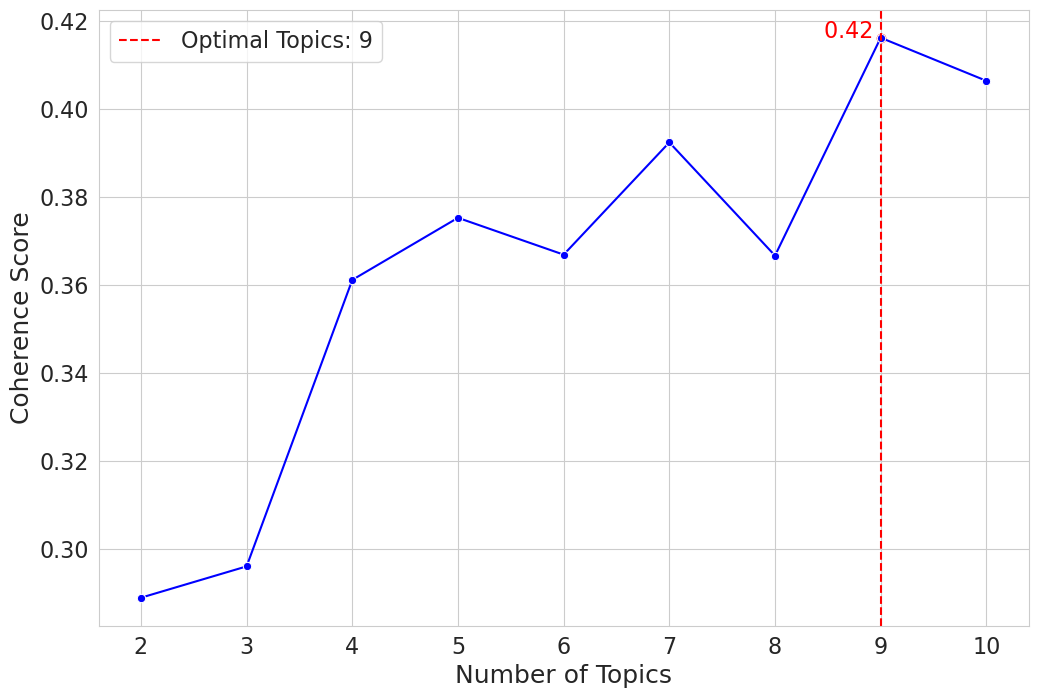

In [22]:
# find the optimal number of topics
optimal_num_topics = coherence['coherence'].idxmax()
print(f'The optimal number of topics is: {optimal_num_topics}')

# plot the coherence scores
def plot_coherence(coherence):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=coherence, x=coherence.index, y='coherence', marker='o', color='b')
    # plt.title('Coherence Score vs. Number of Topics', fontsize=16)
    plt.xlabel('Number of Topics', fontsize=18)
    plt.ylabel('Coherence Score', fontsize=18)
    plt.xticks(coherence.index, fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    # add a vertical line for the optimal number of topics
    optimal_score = coherence.loc[optimal_num_topics, 'coherence']
    plt.axvline(x=optimal_num_topics, color='r', linestyle='--', label=f'Optimal Topics: {optimal_num_topics}')
    plt.scatter(optimal_num_topics, optimal_score, color='r')
    plt.text(optimal_num_topics, optimal_score, f'{optimal_score:.2f} ', horizontalalignment='right', fontsize=16, color='r')
    
    plt.legend(fontsize=16)
    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/coherence_score.png', dpi=300)
    plt.show()


plot_coherence(coherence)

In [10]:
# train the LDA model with the optimal number of topics
lda_model, _ = build_topic_model(lemmatised_docs, dictionary, corpus, optimal_num_topics)

Num Topics: 9, Coherence Score: 0.4161794988727749


In [11]:
# print the words in each topic
for topic_id in range(optimal_num_topics):
    # get the words in the topic
    print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

Topic 0: 0.048*"aviva" + 0.019*"premium" + 0.019*"uki" + 0.014*"renewal" + 0.011*"increase" + 0.010*"price" + 0.009*"year" + 0.008*"item" + 0.007*"risk" + 0.007*"2022"
Topic 1: 0.043*"repair" + 0.041*"car" + 0.017*"vehicle" + 0.014*"lloyds" + 0.013*"garage" + 0.011*"repairer" + 0.008*"report" + 0.008*"hire" + 0.007*"engineer" + 0.007*"haven"
Topic 2: 0.011*"legal" + 0.010*"solicitor" + 0.009*"amtrust" + 0.009*"vitality" + 0.008*"treatment" + 0.007*"medical" + 0.007*"decline" + 0.006*"dog" + 0.006*"illness" + 0.006*"firm"
Topic 3: 0.025*"lv" + 0.022*"medical" + 0.022*"ipa" + 0.016*"misrepresentation" + 0.013*"great" + 0.013*"lakes" + 0.012*"question" + 0.009*"answer" + 0.009*"consumer" + 0.008*"care"
Topic 4: 0.055*"axa" + 0.039*"admiral" + 0.012*"awp" + 0.012*"aa" + 0.009*"treatment" + 0.008*"vitality" + 0.006*"hospital" + 0.006*"astrenska" + 0.005*"delay" + 0.005*"send"
Topic 5: 0.033*"advantage" + 0.025*"cancel" + 0.016*"cancellation" + 0.012*"premium" + 0.011*"send" + 0.011*"email" 

In [12]:
# create a dictionary to map the topic id to a description of the topic
dict_topics = {
    0: "Insurance Premiums and Renewals",
    1: "Car Repair Insurance",
    2: "Legal and Health Insurance",
    3: "Medical Insurance",
    4: "Insurance Companies and Processing",
    5: "Premiums and Cancellations",
    6: "Property Insurance",
    7: "Car Valuation",
    8: "Home Repair Insurance",
}

# print 5 document text with their topics
for i in range(5):
    # choose a random document
    doc_id = random.randint(0, len(lemmatised_docs))
    # get the document's topic distribution
    topic_distribution = lda_model.get_document_topics(corpus[doc_id])
    # get the topic with the highest probability
    topic_id = max(topic_distribution, key=lambda x: x[1])[0]
    # print the document text and the topic
    print(f'File: {train_files[doc_id]}')
    print(f'Topic: {topic_id} - {dict_topics[topic_id]}')
    print(train_data[doc_id][:500])
    print()

File: data/train/positive/DRN-4593623.txt
Topic: 4 - Insurance Companies and Processing
The complaint
Mr S had motor insurance with Admiral Insurance (Gibraltar) Limited (Admiral). He is unhappy that Admiral reduced his No Claims Bonus (NCB) and kept a claim open following an incident where his vehicle collided with a pedestrian. 
What happened
Mr S's car was involved in a collision with a pedestrian, who was slightly injured but said the collision was their fault. Police and ambulance attended but the pedestrian didn't need to go to hospital. Mr S told Admiral, although he didn't 

File: data/train/positive/DRN-4659239.txt
Topic: 0 - Insurance Premiums and Renewals
The complaint
Mr P complains AXA Insurance UK Plc's charged him unfair property insurance premiums. 
What happened
In May 2020 Mr P took out an AXA property insurance policy for a rental property he owns. He was charged a premium of 596. In August 2020 he claimed under the policy for subsidence. The cover's subsidence claim

### Wordclouds

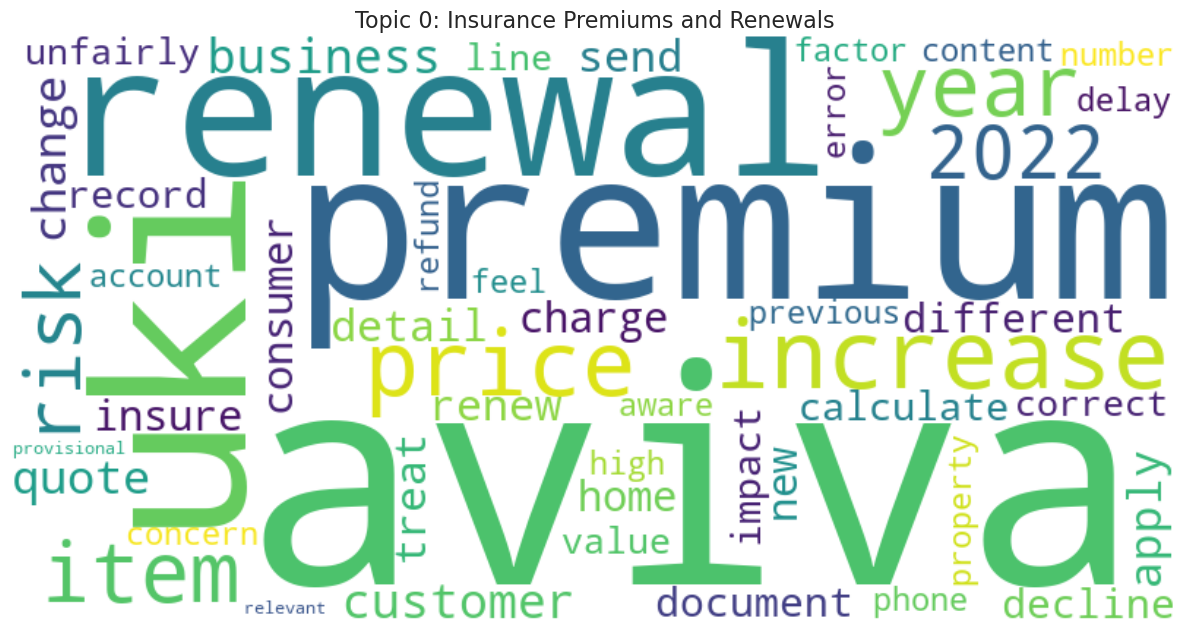

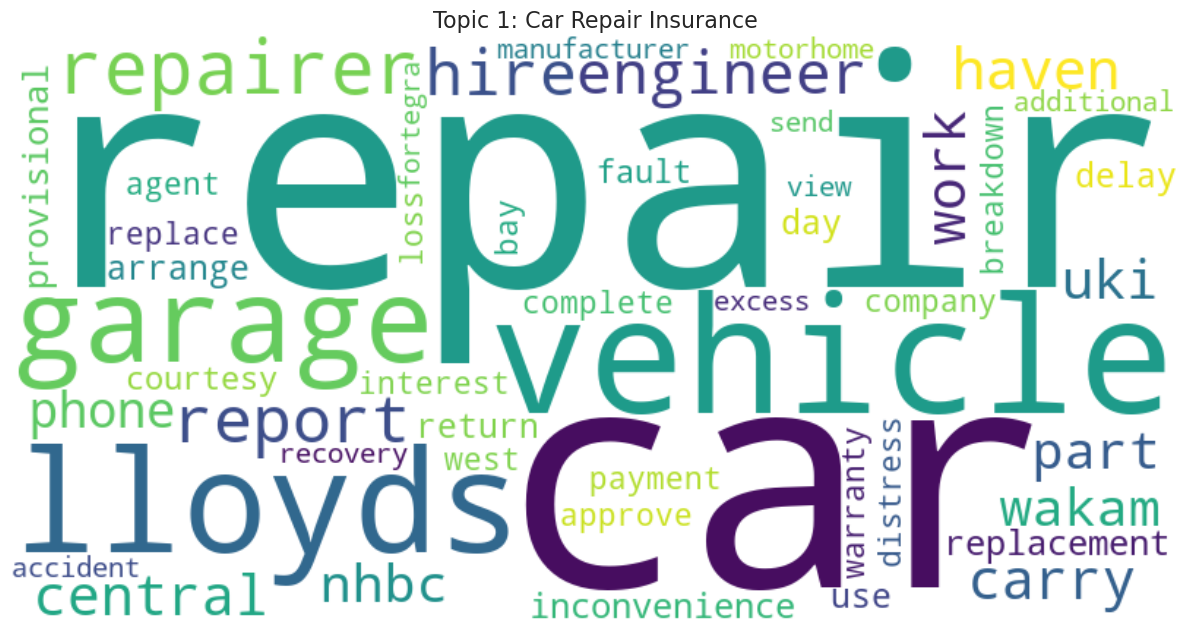

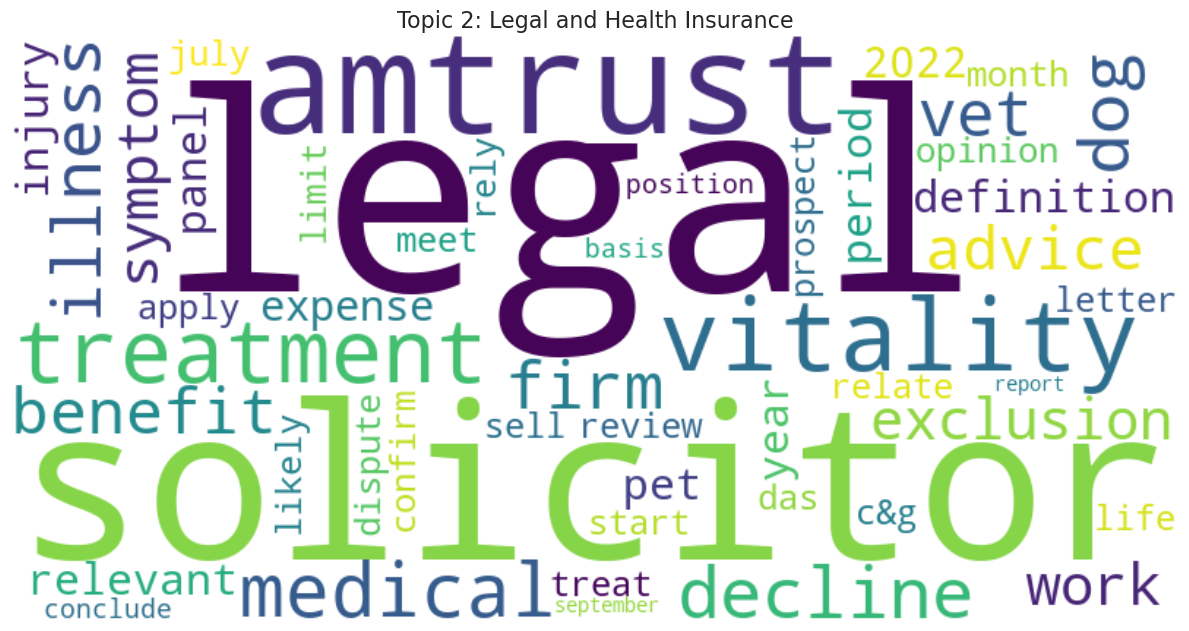

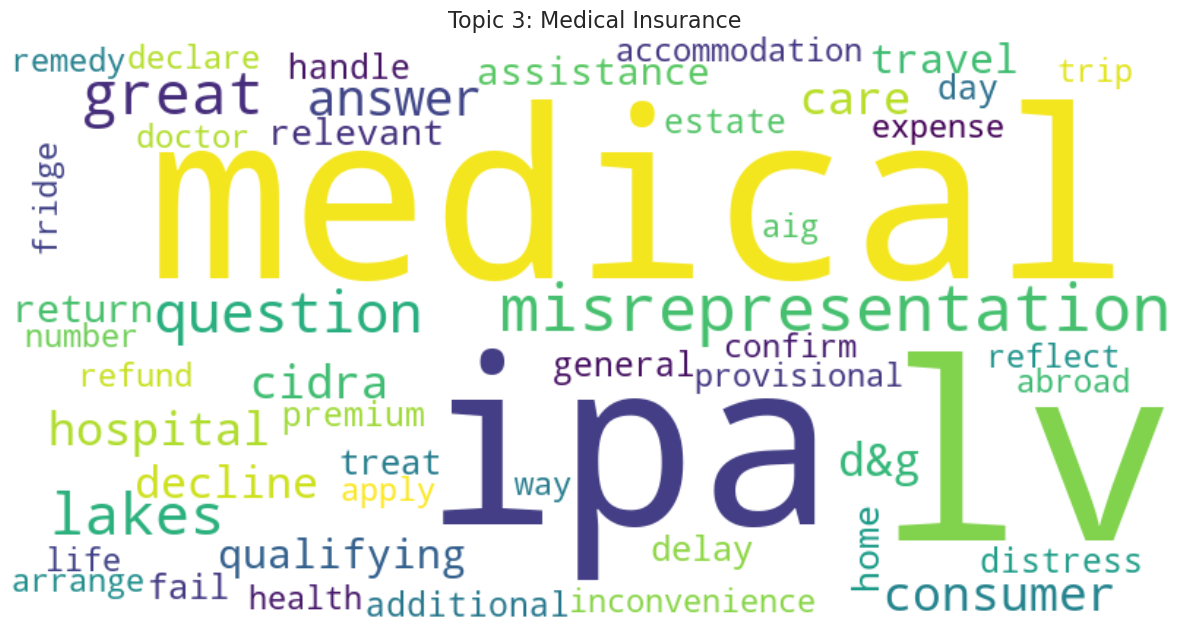

In [24]:
# create a dictionary to map the topic id to a description of the topic
# dict_topics = {
#     0: "Insurance Premiums and Renewals (Aviva, premium increases, renewals)",
#     1: "Car Repair Insurance (car repairs, garages, vehicle issues)",
#     2: "Legal and Health Insurance (legal services, solicitors, medical treatments)",
#     3: "Medical Insurance (medical questions, misrepresentation, consumer care)",
#     4: "Insurance Companies and Processing (AXA, Admiral, treatment delays)",
#     5: "Premiums and Cancellations (policy cancellations, premium refunds, emails)",
#     6: "Property Insurance (RSA, property subsidence, theft, repairs)",
#     7: "Car Valuation (car valuation, settlement, market value)",
#     8: "Home Repair Insurance (property repairs, water leaks, contractors)",
# }

dict_topics = {
    0: "Insurance Premiums and Renewals",
    1: "Car Repair Insurance",
    2: "Legal and Health Insurance",
    3: "Medical Insurance",
    4: "Insurance Companies and Processing",
    5: "Premiums and Cancellations",
    6: "Property Insurance",
    7: "Car Valuation",
    8: "Home Repair Insurance",
}


# draw a word cloud for a topic
def draw_word_cloud(lda_model, topic_id, dict_topics=dict_topics):
    # get the words in the topic
    words = lda_model.show_topic(topic_id, topn=50)
    
    # create a dictionary from the words
    word_dict = {word: score for word, score in words}
    
    # create the word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate_from_frequencies(word_dict)
    
    # plot the word cloud
    plt.figure(figsize=(12, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}: {dict_topics[topic_id]}', fontsize=16)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.savefig(f'plots/topic-{topic_id}-word-cloud.png', dpi=300)
    plt.show()

# draw the word cloud for the topics
for topic_id in range(4):
    draw_word_cloud(lda_model, topic_id)


### Distribution of topics in the dataset

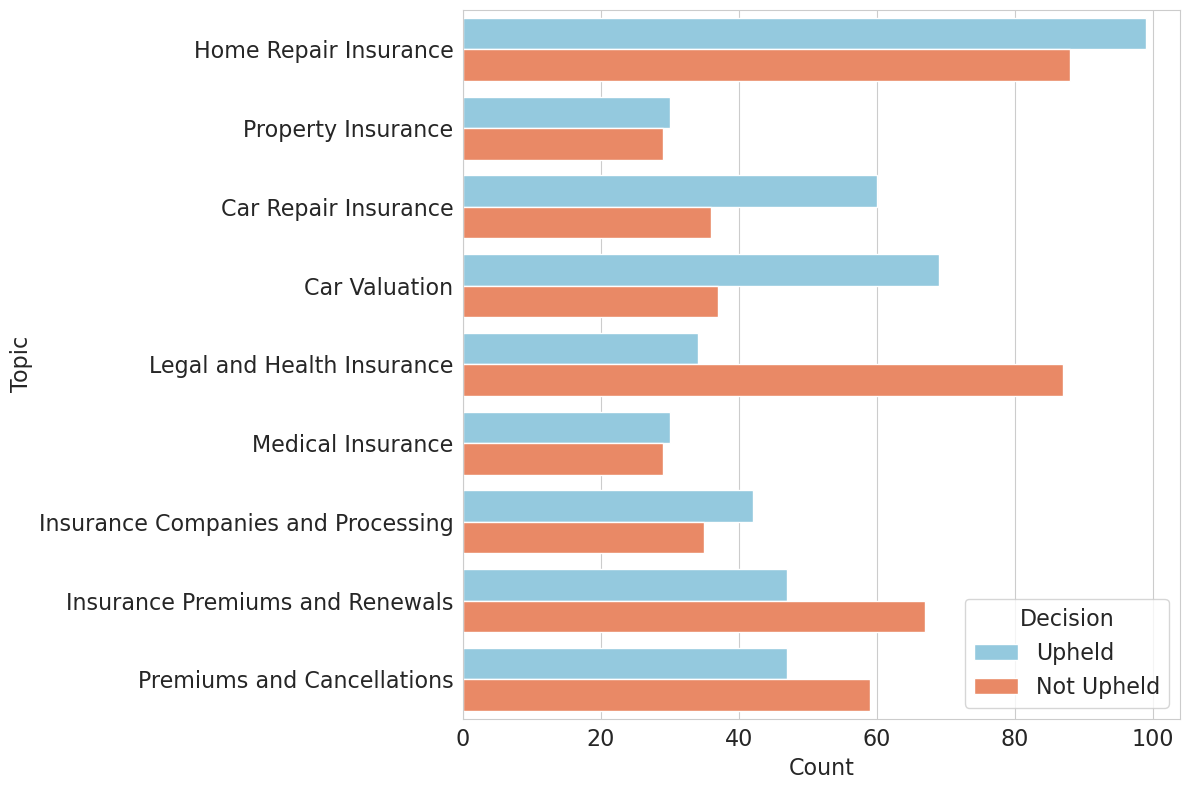

In [48]:
# assign topics to the documents
topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# create a dataframe with the topics
df_topics = pd.DataFrame({'topic': topics, 'topic_label': train_labels})

def plot_topic_distribution(df_topics, dict_topics):
    df_topics['topic_label'] = df_topics['topic_label'].map({1: 'Upheld', 0: 'Not Upheld'})
    df_topics['topic'] = df_topics['topic'].map(dict_topics)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    sns.countplot(y='topic', hue='topic_label', data=df_topics, palette={'Upheld': 'skyblue', 'Not Upheld': 'coral'})
    
    # plt.title('Distribution of Topics in the Dataset', fontsize=16)
    plt.ylabel('Topic', fontsize=16)
    plt.xlabel('Count', fontsize=16)
    legend = plt.legend(title='Decision', fontsize=16, title_fontsize='16', loc='lower right')
    frame = legend.get_frame()


    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution.png', dpi=300)
    plt.show()


plot_topic_distribution(df_topics, dict_topics)

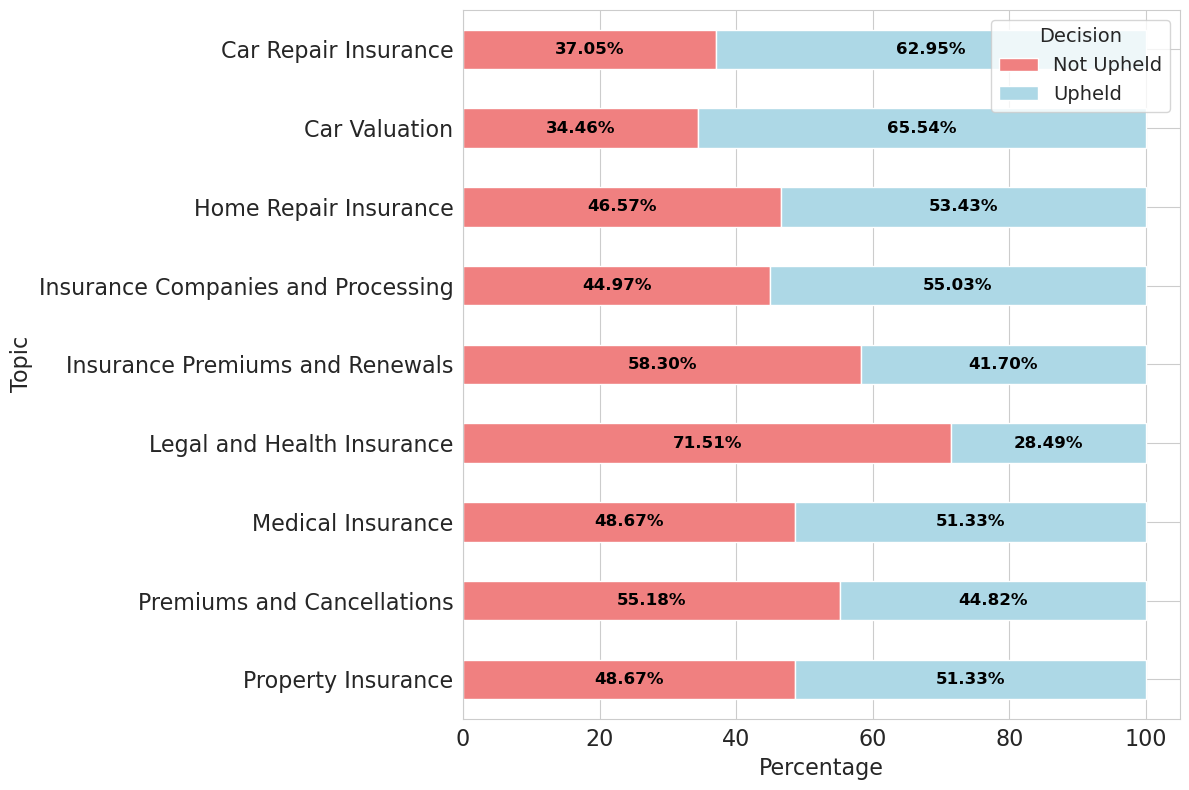

In [50]:
# calculate the topic distribution for each label (percentage)
topic_distribution = df_topics.groupby('topic_label')['topic'].value_counts(normalize=True).unstack()
# dive the topic distribution by the sum of the values in each column
topic_distribution = topic_distribution.div(topic_distribution.sum(axis=0), axis=1)
# multiply the values by 100 to get percentages
topic_distribution = topic_distribution * 100

def plot_distribution_percent(df):

    sns.set_style("whitegrid")
    ax = df.T.plot(kind='barh', stacked=True, figsize=(12, 8), 
                   color={'Upheld': 'lightblue', 'Not Upheld': 'lightcoral'},
                     linewidth=1)

    # plt.title('Distribution of Topics Across Different Insurance Types', fontsize=16, color='#333333')
    plt.xlabel('Percentage', fontsize=16)
    plt.ylabel('Topic', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    # improve legend aesthetics
    legend = plt.legend(title='Decision', fontsize=14, title_fontsize='14', loc='upper right')

    # annotate percentage values on the bars
    for p in ax.patches:
        width = p.get_width()
        label_text = f'{width:.2f}%'
        label_x_pos = p.get_x() + width / 2
        label_y_pos = p.get_y() + p.get_height() / 2
        ax.annotate(label_text, (label_x_pos, label_y_pos), ha='center',
                     va='center', fontsize=12, color='black', fontweight='bold')

    # reverse the y-axis to have the top values at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution-percent.png', dpi=300)
    
    # show plot
    plt.show()


plot_distribution_percent(topic_distribution)

In [16]:
# visualise the topics 
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.039614  0.131051       1        1  22.315406
0      0.015877 -0.042911       2        1  12.555234
2      0.100180  0.032756       3        1  12.178885
7     -0.151369 -0.088201       4        1  10.691428
1     -0.136679  0.010681       5        1  10.091514
5      0.015693 -0.110050       6        1   9.035976
4      0.053873 -0.030171       7        1   8.230536
6      0.007284  0.149037       8        1   7.731731
3      0.134755 -0.052190       9        1   7.169290, topic_info=            Term         Freq        Total Category  logprob  loglift
631          car  3147.000000  3147.000000  Default  30.0000  30.0000
1561       aviva  2279.000000  2279.000000  Default  29.0000  29.0000
1827         axa  1641.000000  1641.000000  Default  28.0000  28.0000
149       repair  3114.000000  3114.000000  Default  27.0000  27.0000
286          rsa  1127.000000  1127.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
222        delay   117.819668  1601.397722   Topic9  -5.3878   0.0259
405   additional   102.740484   763.459005   Topic9  -5.5247   0.6297
220          day   107.784427  1114.261198   Topic9  -5.4768   0.2995
553      premium   108.472563  1570.883453   Topic9  -5.4704  -0.0375
51      distress   102.298090  1038.336417   Topic9  -5.5290   0.3179

[601 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1295      1  0.006845      00
1295      2  0.017113      00
1295      4  0.818006      00
1295      5  0.020536      00
1295      6  0.130060      00
...     ...       ...     ...
307       8  0.057632    year
307       9  0.054242    year
2116      1  0.958212  zurich
2116      2  0.005115  zurich
2116      4  0.035805  zurich

[2239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 3, 8, 2, 6, 5, 7, 4])